In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
beer_data=pd.read_csv('beer.csv') #read csv data #into a dataframe using pd.read_csv
beer_data.head(10) #head() prints top 5 rows in the data set

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,2015-01-01,"27,3","23,9","32,5",0,0,25.461
1,2015-01-02,"27,02","24,5","33,5",0,0,28.972
2,2015-01-03,"24,82","22,4","29,9",0,1,30.814
3,2015-01-04,"23,98","21,5","28,6","1,2",1,29.799
4,2015-01-05,"23,82",21,"28,3",0,0,28.900
5,2015-01-06,"23,78","20,1","30,5","12,2",0,28.218
6,2015-01-07,24,"19,5","33,7",0,0,29.732
7,2015-01-08,"24,9","19,5","32,8","48,6",0,28.397
8,2015-01-09,"28,2","21,9",34,"4,4",0,24.886
9,2015-01-10,"26,76","22,1","34,2",0,1,37.937


In [2]:
beer_data.columns=['Date','Temperature_Median','Temperature_Min','Temperature_Max',
                   'Rainfall','Weekend','Consumption_litres']

In [3]:
beer_data['Temperature_Median'] = beer_data['Temperature_Median'].str.replace(',','.').astype('float')
beer_data['Temperature_Min'] = beer_data['Temperature_Min'].str.replace(',','.').astype('float')
beer_data['Temperature_Max'] = beer_data['Temperature_Max'].str.replace(',','.').astype('float')
beer_data['Rainfall'] = beer_data['Rainfall'].str.replace(',','.').astype('float')
beer_data.info() #info() outputs total number of rows,number of #columns and null values present in each of them.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                365 non-null    object 
 1   Temperature_Median  365 non-null    float64
 2   Temperature_Min     365 non-null    float64
 3   Temperature_Max     365 non-null    float64
 4   Rainfall            365 non-null    float64
 5   Weekend             365 non-null    int64  
 6   Consumption_litres  365 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 20.1+ KB


In [4]:
#drop Blank rows read from the input CSV and describe shows all #statistics 
beer_data = beer_data.dropna()
beer_data.describe()

,Temperature_Median,Temperature_Min,Temperature_Max,Rainfall,Weekend,Consumption_litres
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.226356,17.461370,26.611507,5.196712,0.284932,25.401367
std,3.180108,2.826185,4.317366,12.417844,0.452001,4.399143
min,12.900000,10.600000,14.500000,0.000000,0.000000,14.343000
25%,19.020000,15.300000,23.800000,0.000000,0.000000,22.008000
50%,21.380000,17.900000,26.900000,0.000000,0.000000,24.867000
75%,23.280000,19.600000,29.400000,3.200000,1.000000,28.631000
max,28.860000,24.500000,36.500000,94.800000,1.000000,37.937000


In [5]:
X = beer_data.drop(columns=['Date', 'Consumption_litres'])
Y = beer_data['Consumption_litres']

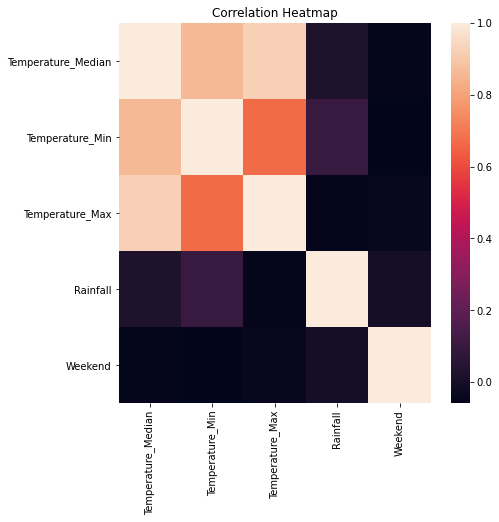

In [6]:
plt.figure(figsize=(7,7))
sns.heatmap(X.corr())
plt.title('Correlation Heatmap')
plt.show()

In the heat map here we can see that the Temperature_Median, Temperature_Min, Temperature_Max are highly collinear as their score is close to 1. Eliminating the unwanted features using VIF in next steps

In [7]:
vif = pd.DataFrame()
vif['Features'] = X.columns
#calculating variance factor for rach column 
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Features,VIF Factor
0,Temperature_Median,1087.797835
1,Temperature_Min,249.112601
2,Temperature_Max,436.529190
3,Rainfall,1.220276
4,Weekend,1.374283


Temperature features have really high score of VIF. We first eliminate the feature with high score and re run VIF function to see if there is any change in the scores and repeat this process until all of the variables have a score <5

In [10]:
# creating function so it becomes easy to run 
# giving high vif score as an argument in the function and it is dropped from the dataframe 

def check_vif_drop_column(X,column_name): 
    X = X.drop(columns=column_name) 
    vif = pd.DataFrame() 
    vif['Features'] = X.columns
    vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif,X
vif1,X = check_vif_drop_column(X,'Temperature_Median')
vif1

,Features,VIF Factor
0,Temperature_Min,62.903327
1,Temperature_Max,61.914485
2,Rainfall,1.215937
3,Weekend,1.374087


The VIF scores of Temperature_Min and Temperature_Max have decreased and lets eliminate Temperature_Min in this step as VIF is higher than Temperature_Max and recheck the scores

In [11]:
vif2,X = check_vif_drop_column(X,'Temperature_Min')
vif2

,Features,VIF Factor
0,Temperature_Max,1.528790
1,Rainfall,1.163160
2,Weekend,1.373842


### moving to model building since all the variables have VIF scores in allowed range (0-5)

split the data into X_train,X_test,Y_train,Y_test.
- X_train,Y_train are used in training process and X_test,Y_test for testing the model. 
- train_test_split function is imported from sklearn.model_selection which does the splitting job
- This function has a parameter ‘test_size’ that allows the user to set the proportion of data to be used for testing the model (here we use 0.25)


In [12]:
def split_train_data(X,Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
    return(X_train, X_test, Y_train, Y_test)

X_train, X_test, Y_train, Y_test = split_train_data(X,Y)

## building the model

In [13]:
def model_fit(model,X_train, Y_train):
    model = LinearRegression() 
    model.fit(X_train, Y_train)
    return model

lin_model = model_fit(LinearRegression,X_train, Y_train)

In [16]:
def scores_(model,X,Y):
    y_predict = model.predict(X)
    rmse = (np.sqrt(mean_squared_error(Y, y_predict)))
    r2 = r2_score(Y, y_predict)
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))

print("The model performance of training set")
print("--------------------------------------")
scores_(lin_model,X_train,Y_train)
print("--------------------------------------")
print("The model performance of testing set")
scores_(lin_model,X_test,Y_test)

The model performance of training set
--------------------------------------
RMSE is 2.3565394917987748
R2 score is 0.7167497963229421
--------------------------------------
The model performance of testing set
RMSE is 2.1884108134344564
R2 score is 0.7388732891477832


This data set fits properly with linear regression, but we find data sets which fits with high accuracy on train data set but when predicted with test data the accuracy is really low. This scenario is called overfitting.